<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/Assignment_4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Team Members**

Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

# **Contribution of each member**

XXX By Mesay

XXX By Zilal

XXX By Jianci

# **Reference**
https://campuswire.com/c/GB46E5679/feed/587

https://liangfgithub.github.io/Coding/F24_Coding4.pdf

# **Setting**

In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# import all libraries
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import multivariate_normal

from matplotlib.colors import LogNorm

from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture

# **Part I: Gaussian Mixtures**

reference:

https://liangfgithub.github.io/PSL/w7/w7_3_EM.html

https://campuswire.com/c/GB46E5679/feed/589 (hint)


In [3]:
#change with your path
path_to_data='/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/CA/'

Text(0, 0.5, 'Duration')

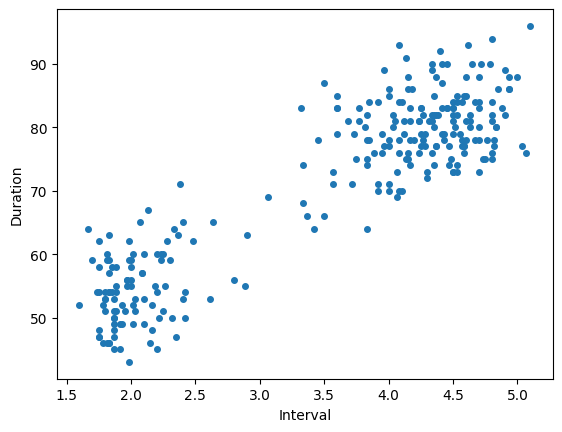

In [4]:
data = pd.read_table(path_to_data+"faithful.dat", sep="\s+", index_col=0)
plt.scatter(data['eruptions'], data['waiting'], 16)
plt.xlabel('Interval')
plt.ylabel('Duration')

In [5]:
data.head()

,eruptions,waiting
1,3.600,79
2,1.800,54
3,3.333,74
4,2.283,62
5,4.533,85


In [6]:
#create a matrix for all sample sizes for G, the corresponding p, u
def create_s_mtrx(G,n,s_interval=10): #sample size interval is default to 10, not required by instruction, but will need to handle G >2 as required by the instruction
  #matrix of G/ aka Z
  G_mtrx = np.arange(1,G+1,1)
  #sample size by group
  s_mtrx = s_interval*2**(G_mtrx-1)

  cumsum_s_mtrx =  np.cumsum(s_mtrx, axis =0)
  cumsum_s_mtrx

  #anything above limit taking 0s
  G_mtrx[cumsum_s_mtrx > n] = 0
  s_mtrx[cumsum_s_mtrx > n] = 0
  cumsum_s_mtrx[cumsum_s_mtrx > n] = 0
  #print(cumsum_s_mtrx)

  #biggest possible matrix
  max_G = np.where(cumsum_s_mtrx>0)[0][-1]+2

  final_G = min(max_G,G)
  last_s_mtrx = n - sum(s_mtrx[0:final_G-1])
  s_mtrx[final_G-1]=last_s_mtrx
  try:
    s_mtrx[final_G:]=0
  except:
    pass

  G_mtrx_final = np.arange(1,final_G+1,1)
  s_mtrx_final = s_mtrx[0:final_G]


  # initialize matrix of p
  p_mtrx = s_mtrx_final /n

  #create a new dim in data to show the G assignment
  G_assignment = np.repeat(G_mtrx_final,s_mtrx_final)
  p_assignment = np.repeat(p_mtrx,s_mtrx_final)

  #data with g assignment
  data_wg = data.copy()
  data_wg['G'] = G_assignment
  data_wg['p'] = p_assignment

  # calculate U by group for the two dimenison
  # keep column names so it's easier to understand
  mean_df = data_wg.groupby('G').mean().transpose()
  #u_by_k.columns = [ 'G','eruptions_avg',	'waiting_avg']

  return   G_mtrx_final, s_mtrx_final, p_mtrx, final_G, data_wg, mean_df


In [164]:
#number of componants
G=2
#sample size
n=len(data)

G_mtrx, s_mtrx, p_mtrx, final_G,data_wg, mean_df= create_s_mtrx(G,n,s_interval=10)

In [165]:
G_mtrx

array([1, 2])

In [166]:
s_mtrx

array([ 10, 262])

In [167]:
p_mtrx

array([0.03676471, 0.96323529])

In [168]:
data_wg

,eruptions,waiting,G,p
1,3.600,79,1,0.036765
2,1.800,54,1,0.036765
3,3.333,74,1,0.036765
4,2.283,62,1,0.036765
5,4.533,85,1,0.036765
...,...,...,...,...
268,4.117,81,2,0.963235
269,2.150,46,2,0.963235
270,4.417,90,2,0.963235
271,1.817,46,2,0.963235


In [169]:
data_mtrx = data[['eruptions','waiting']].to_numpy().reshape(-1,1)

In [170]:
data_wg_cal = data_wg.copy()

In [171]:
mean_df

G,1,2
eruptions,3.303200,3.494828
waiting,71.800000,70.862595
p,0.036765,0.963235


In [204]:
mean_temp = mean_df.iloc[0:G].T
mean_temp

,eruptions,waiting
G,,
1,3.303200,71.800000
2,3.494828,70.862595


In [215]:
mean_temp['ug'] = [np.array(row) for row in mean_temp[['eruptions','waiting']].to_numpy()]
mean_temp

,eruptions,waiting,ug
G,,,
1,3.303200,71.800000,"[3.3032000000000004, 71.8]"
2,3.494828,70.862595,"[3.494828244274809, 70.86259541984732]"


In [219]:
mean_temp['ug'].to_numpy()

array([array([ 3.3032, 71.8   ]), array([ 3.49482824, 70.86259542])],
      dtype=object)

In [220]:
mean_mtrx_by_G = np.vstack(mean_temp['ug'].values)
mean_mtrx_by_G

array([[ 3.3032    , 71.8       ],
       [ 3.49482824, 70.86259542]])

In [221]:
for i in range(0,final_G):
  print(mean_mtrx_by_G[i])

[ 3.3032 71.8   ]
[ 3.49482824 70.86259542]


In [173]:
mean_mtrx

array([[3.30320000e+00, 3.49482824e+00],
       [7.18000000e+01, 7.08625954e+01],
       [3.67647059e-02, 9.63235294e-01]])

In [174]:

data_erp = data_wg_cal['eruptions'].to_numpy().reshape(-1,1) - mean_mtrx[0]#average eruptions time
data_erp = pd.DataFrame(data_erp)
data_erp.columns= ['erp_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [190]:
data_erp

,erp_diff_1,erp_diff_2
0,0.2968,0.105172
1,-1.5032,-1.694828
2,0.0298,-0.161828
3,-1.0202,-1.211828
4,1.2298,1.038172
...,...,...
267,0.8138,0.622172
268,-1.1532,-1.344828
269,1.1138,0.922172
270,-1.4862,-1.677828


In [175]:
data_wait = data_wg_cal['waiting'].to_numpy().reshape(-1,1) -mean_mtrx[1]#average waiting time
data_wait = pd.DataFrame(data_wait)
data_wait.columns= ['wait_diff_'+ col for col in G_mtrx.astype('str').tolist()]

In [176]:
data_e_m = pd.DataFrame(mean_mtrx[0]).transpose()
data_e_m.columns= ['erp_'+ col for col in G_mtrx.astype('str').tolist()]

In [177]:
data_w_m = pd.DataFrame(mean_mtrx[1]).transpose()
data_w_m.columns= ['wait_'+ col for col in G_mtrx.astype('str').tolist()]

In [178]:
data_p = pd.DataFrame(mean_mtrx[2]).transpose()
data_p.columns= ['p_'+ col for col in G_mtrx.astype('str').tolist()]

In [179]:


data_wg_cal = data_wg_cal.merge(data_p, how='cross').merge(data_e_m,how='cross').merge(data_w_m,how='cross')
data_wg_cal = pd.concat([data_wg_cal,data_erp,data_wait],axis = 1)
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405


In [180]:
data_wg_cal['erp_mean']=np.repeat(mean_mtrx[0],s_mtrx)
data_wg_cal['erp_diff']=data_wg_cal['eruptions']-data_wg_cal['erp_mean']
data_wg_cal['wait_mean']=np.repeat(mean_mtrx[1],s_mtrx)
data_wg_cal['wait_diff']=data_wg_cal['waiting']-data_wg_cal['wait_mean']

In [181]:
data_wg_cal['xi']= [np.reshape(np.array(row),(1,2)) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]
data_wg_cal['u']= [np.reshape(np.array(row),(1,2)) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [182]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,erp_diff_1,erp_diff_2,wait_diff_1,wait_diff_2,erp_mean,erp_diff,wait_mean,wait_diff,xi,u
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.2968,0.105172,7.2,8.137405,3.303200,0.296800,71.800000,7.200000,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]"
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.5032,-1.694828,-17.8,-16.862595,3.303200,-1.503200,71.800000,-17.800000,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]"
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.0298,-0.161828,2.2,3.137405,3.303200,0.029800,71.800000,2.200000,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]"
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.0202,-1.211828,-9.8,-8.862595,3.303200,-1.020200,71.800000,-9.800000,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]"
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.2298,1.038172,13.2,14.137405,3.303200,1.229800,71.800000,13.200000,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,0.8138,0.622172,9.2,10.137405,3.494828,0.622172,70.862595,10.137405,"[[4.117, 81.0]]","[[3.494828244274809, 70.86259541984732]]"
268,2.150,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.1532,-1.344828,-25.8,-24.862595,3.494828,-1.344828,70.862595,-24.862595,"[[2.15, 46.0]]","[[3.494828244274809, 70.86259541984732]]"
269,4.417,90,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,1.1138,0.922172,18.2,19.137405,3.494828,0.922172,70.862595,19.137405,"[[4.417, 90.0]]","[[3.494828244274809, 70.86259541984732]]"
270,1.817,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,-1.4862,-1.677828,-25.8,-24.862595,3.494828,-1.677828,70.862595,-24.862595,"[[1.817, 46.0]]","[[3.494828244274809, 70.86259541984732]]"


In [183]:
data_wg_cal['xi_minus_u']= data_wg_cal['xi']-data_wg_cal['u']

In [184]:
data_wg_cal['xi_minus_u_T']= ([np.reshape(np.array(row),(2,1)) for row in data_wg_cal['xi']-data_wg_cal['u']])

In [185]:
data_wg_cal.head()

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,...,wait_diff_1,wait_diff_2,erp_mean,erp_diff,wait_mean,wait_diff,xi,u,xi_minus_u,xi_minus_u_T
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,7.2,8.137405,3.3032,0.2968,71.8,7.2,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]","[[0.29679999999999973, 7.200000000000003]]","[[0.29679999999999973], [7.200000000000003]]"
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-17.8,-16.862595,3.3032,-1.5032,71.8,-17.8,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.5032000000000003], [-17.799999999999997]]"
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,2.2,3.137405,3.3032,0.0298,71.8,2.2,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]","[[0.029799999999999827, 2.200000000000003]]","[[0.029799999999999827], [2.200000000000003]]"
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-9.8,-8.862595,3.3032,-1.0202,71.8,-9.8,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.0202000000000004], [-9.799999999999997]]"
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,13.2,14.137405,3.3032,1.2298,71.8,13.2,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]","[[1.2298, 13.200000000000003]]","[[1.2298], [13.200000000000003]]"


In [186]:

 #CA4,instruction p2, after 'Testing'
sigma = (data_wg_cal['xi_minus_u']*data_wg_cal['xi_minus_u_T']).sum(axis = 0)/n
sigma

array([[  1.29663847,  13.93278021],
       [ 13.93278021, 184.11269645]])

In [187]:
# find determinant of sigma |sigma|
sigma_det = np.linalg.det(sigma)
sigma_det

44.605241387012626

E-Step
https://campuswire.com/c/GB46E5679/feed/589

In [189]:
data_wg_cal['xi_minus_u_T']

,xi_minus_u_T
0,"[[0.29679999999999973], [7.200000000000003]]"
1,"[[-1.5032000000000003], [-17.799999999999997]]"
2,"[[0.029799999999999827], [2.200000000000003]]"
3,"[[-1.0202000000000004], [-9.799999999999997]]"
4,"[[1.2298], [13.200000000000003]]"
...,...
267,"[[0.6221717557251911], [10.137404580152676]]"
268,"[[-1.344828244274809], [-24.862595419847324]]"
269,"[[0.922171755725191], [19.137404580152676]]"
270,"[[-1.677828244274809], [-24.862595419847324]]"


In [227]:
data_wg_cal['eruptions']

,eruptions
0,3.600
1,1.800
2,3.333
3,2.283
4,4.533
...,...
267,4.117
268,2.150
269,4.417
270,1.817


In [234]:
(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0]).T*sigma**2*(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

ValueError: operands could not be broadcast together with shapes (2,272) (2,2) 

In [235]:
data_wg_cal

,eruptions,waiting,G,p,p_1,p_2,erp_1,erp_2,wait_1,wait_2,...,wait_diff_1,wait_diff_2,erp_mean,erp_diff,wait_mean,wait_diff,xi,u,xi_minus_u,xi_minus_u_T
0,3.600,79,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,7.2,8.137405,3.303200,0.296800,71.800000,7.200000,"[[3.6, 79.0]]","[[3.3032000000000004, 71.8]]","[[0.29679999999999973, 7.200000000000003]]","[[0.29679999999999973], [7.200000000000003]]"
1,1.800,54,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-17.8,-16.862595,3.303200,-1.503200,71.800000,-17.800000,"[[1.8, 54.0]]","[[3.3032000000000004, 71.8]]","[[-1.5032000000000003, -17.799999999999997]]","[[-1.5032000000000003], [-17.799999999999997]]"
2,3.333,74,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,2.2,3.137405,3.303200,0.029800,71.800000,2.200000,"[[3.333, 74.0]]","[[3.3032000000000004, 71.8]]","[[0.029799999999999827, 2.200000000000003]]","[[0.029799999999999827], [2.200000000000003]]"
3,2.283,62,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-9.8,-8.862595,3.303200,-1.020200,71.800000,-9.800000,"[[2.283, 62.0]]","[[3.3032000000000004, 71.8]]","[[-1.0202000000000004, -9.799999999999997]]","[[-1.0202000000000004], [-9.799999999999997]]"
4,4.533,85,1,0.036765,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,13.2,14.137405,3.303200,1.229800,71.800000,13.200000,"[[4.533, 85.0]]","[[3.3032000000000004, 71.8]]","[[1.2298, 13.200000000000003]]","[[1.2298], [13.200000000000003]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267,4.117,81,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,9.2,10.137405,3.494828,0.622172,70.862595,10.137405,"[[4.117, 81.0]]","[[3.494828244274809, 70.86259541984732]]","[[0.6221717557251911, 10.137404580152676]]","[[0.6221717557251911], [10.137404580152676]]"
268,2.150,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-25.8,-24.862595,3.494828,-1.344828,70.862595,-24.862595,"[[2.15, 46.0]]","[[3.494828244274809, 70.86259541984732]]","[[-1.344828244274809, -24.862595419847324]]","[[-1.344828244274809], [-24.862595419847324]]"
269,4.417,90,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,18.2,19.137405,3.494828,0.922172,70.862595,19.137405,"[[4.417, 90.0]]","[[3.494828244274809, 70.86259541984732]]","[[0.922171755725191, 19.137404580152676]]","[[0.922171755725191], [19.137404580152676]]"
270,1.817,46,2,0.963235,0.036765,0.963235,3.3032,3.494828,71.8,70.862595,...,-25.8,-24.862595,3.494828,-1.677828,70.862595,-24.862595,"[[1.817, 46.0]]","[[3.494828244274809, 70.86259541984732]]","[[-1.677828244274809, -24.862595419847324]]","[[-1.677828244274809], [-24.862595419847324]]"


In [236]:
chk = (np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

In [237]:
[np.reshape(np.array(row),(1,2)) for row in chk]

[array([[0.2968, 7.2   ]]),
 array([[ -1.5032, -17.8   ]]),
 array([[0.0298, 2.2   ]]),
 array([[-1.0202, -9.8   ]]),
 array([[ 1.2298, 13.2   ]]),
 array([[ -0.4202, -16.8   ]]),
 array([[ 1.3968, 16.2   ]]),
 array([[ 0.2968, 13.2   ]]),
 array([[ -1.3532, -20.8   ]]),
 array([[ 1.0468, 13.2   ]]),
 array([[ -1.4702, -17.8   ]]),
 array([[ 0.6138, 12.2   ]]),
 array([[0.8968, 6.2   ]]),
 array([[ -1.5532, -24.8   ]]),
 array([[ 1.3968, 11.2   ]]),
 array([[ -1.1362, -19.8   ]]),
 array([[-1.5532, -9.8   ]]),
 array([[ 1.4968, 12.2   ]]),
 array([[ -1.7032, -19.8   ]]),
 array([[0.9468, 7.2   ]]),
 array([[ -1.5032, -20.8   ]]),
 array([[ -1.5532, -24.8   ]]),
 array([[0.1468, 6.2   ]]),
 array([[-0.2362, -2.8   ]]),
 array([[1.2298, 2.2   ]]),
 array([[ 0.2968, 11.2   ]]),
 array([[ -1.3362, -16.8   ]]),
 array([[0.7798, 4.2   ]]),
 array([[0.5468, 6.2   ]]),
 array([[1.1298, 7.2   ]]),
 array([[0.9968, 1.2   ]]),
 array([[1.1638, 5.2   ]]),
 array([[ 0.0638, -5.8   ]]),
 array([[0.7

In [231]:
(np.column_stack((data_wg_cal['eruptions'],data_wg_cal['waiting']))- mean_mtrx_by_G[0])

array([[ 2.9680e-01,  7.2000e+00],
       [-1.5032e+00, -1.7800e+01],
       [ 2.9800e-02,  2.2000e+00],
       [-1.0202e+00, -9.8000e+00],
       [ 1.2298e+00,  1.3200e+01],
       [-4.2020e-01, -1.6800e+01],
       [ 1.3968e+00,  1.6200e+01],
       [ 2.9680e-01,  1.3200e+01],
       [-1.3532e+00, -2.0800e+01],
       [ 1.0468e+00,  1.3200e+01],
       [-1.4702e+00, -1.7800e+01],
       [ 6.1380e-01,  1.2200e+01],
       [ 8.9680e-01,  6.2000e+00],
       [-1.5532e+00, -2.4800e+01],
       [ 1.3968e+00,  1.1200e+01],
       [-1.1362e+00, -1.9800e+01],
       [-1.5532e+00, -9.8000e+00],
       [ 1.4968e+00,  1.2200e+01],
       [-1.7032e+00, -1.9800e+01],
       [ 9.4680e-01,  7.2000e+00],
       [-1.5032e+00, -2.0800e+01],
       [-1.5532e+00, -2.4800e+01],
       [ 1.4680e-01,  6.2000e+00],
       [-2.3620e-01, -2.8000e+00],
       [ 1.2298e+00,  2.2000e+00],
       [ 2.9680e-01,  1.1200e+01],
       [-1.3362e+00, -1.6800e+01],
       [ 7.7980e-01,  4.2000e+00],
       [ 5.4680e-01,

In [225]:
data_wg_cal['xi']- mean_mtrx_by_G[i]

ValueError: operands could not be broadcast together with shapes (272,) (2,) 

In [ ]:
np.array(data_wg_cal['xi_minus_ug_T'])*(sigma**-1)*data_wg_cal['xi_minus_ug']

In [ ]:
#create the term for loglik function
data_wg_cal['loglik_term'] = data_wg_cal['p']*(np.exp(-0.5*data_wg_cal['xi_minus_ug_T']*(sigma**-1)*data_wg_cal['xi_minus_ug']))

In [ ]:
#marginal likely hoold function
m_col = data_wg_cal.columns.tolist()
m_col
erp_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('erp_diff_')]]
erp_diff_G_mtrx.head()


In [ ]:
wait_diff_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('wait_diff_')]]
wait_diff_G_mtrx.head()

In [ ]:
p_G_mtrx= data_wg_cal[[c for c in m_col if c.startswith('p_')]]
p_G_mtrx.head()

In [ ]:
sigma

In [ ]:
sigma**-1

In [ ]:
a = np.array(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])

In [ ]:
np.dot((sigma**-1),a.T)

In [ ]:
for i in G_mtrx:
  #print(i)
  i = (i).astype('str')
  #print(ci)
  np.numpy(data_wg_cal[['erp_diff_'+i,'wait_diff_'+i]])
  mlf = data_wg_cal['p_'+i]*np.exp(-0.5*())
  print(mlf.head())

In [ ]:
mlf

In [ ]:
[itm2+itm1 for itm1 in G_mtrx.astype('str').tolist() for itm2 in ['p_','erp_diff_','wait_diff_']]

In [ ]:
['erp_diff_','wait_diff_']+'1'

In [ ]:
'erp_diff_'+G_mtrx.astype('str').tolist()

In [ ]:
G_mtrx = data_wg_cal[[c for c in m_col if c.endswith('erp_diff_')]]
erp_diff_G_mtrx

In [ ]:
#initialize p1:pn
#for the G = 2 case, start with assuming 10 samples from G1, which will
#result in p1-hat = 10/n

p1 = s_interval/n
p1

In [ ]:
p2 = 1-p1
p2

In [ ]:
u1 = np.mean(data,axis = 0)
u1

In [ ]:
#initialize a matrix for p with 0s, output required for E-step
p_mtrx = np.zeros((n,G))
p_mtrx.shape

Estep function: This function should return an n-by-G matrix, where the (i, j)th entry represents the
conditional probability P(Zi = k | xi). Here i ranges from 1 to n and k ranges from 1 to G.


Mstep function: This function should return the updated parameters for the Gaussian mixture model.


loglik function: This function computes the log-likelihood of the data given the parameters.

myEM function (main function): Inside this function, you can call the Estep and Mstep functions. The
function should take the following inputs and return the estimated parameters and log-likelihood (via
the loglik function)

# **Part II: HMM**

Baum-Welch Algorihtm

Viterbi Algorihtm

# **================ CODE ARCHIVE ================================**

In [ ]:
# TEST PANDA WITH MATRIX
matrix_1 = pd.DataFrame([[1, 2], [3, 4]])

In [ ]:
matrix_1

In [ ]:
# TEST PANDA WITH MATRIX
matrix_2 = pd.DataFrame([[[1,2],[3, 4]], [[5, 6],[7,8]]])

In [ ]:
matrix_2

In [ ]:
matrix_3 = pd.DataFrame([[np.zeros((2,3))], [np.zeros((3,2))]])
matrix_3

In [ ]:
data_wg_cal.head()

In [ ]:
data_wg_cal['x_i']= [np.array(row) for row in data_wg_cal[['eruptions','waiting']].to_numpy()]

In [ ]:
data_wg_cal['u_g']= [np.array(row) for row in data_wg_cal[['erp_mean','wait_mean']].to_numpy()]

In [ ]:
data_wg_cal

In [ ]:
data_wg_cal['x_i'] - data_wg_cal['u_g']

In [ ]:

#silly way to calculate sigma - result match
# [a,b] * [a,b].T is bascially a^2 +ab+ab+ b^2
#data_wg_cal[['eruptions_2',	'waiting_2']] = data_wg_cal[[	'eruptions',	'waiting']]**2
#data_wg_cal[['erp_mean_2',	'wait_mean_2']] = data_wg_cal[[	'erp_mean',	'wait_mean']]**2
#data_wg_cal['eruptions_erp_mean'] = data_wg_cal['eruptions']*data_wg_cal['erp_mean']
#data_wg_cal['waiting_wait_mean'] = data_wg_cal['waiting']*data_wg_cal['wait_mean']
data_wg_cal[['erp_diff_2',	'wait_diff_2']]  = data_wg_cal[[	'erp_diff',	'wait_diff']]**2
data_wg_cal['erp_wait_diff']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']
data_wg_cal['erp_wait_diff_again']  = data_wg_cal['erp_diff']*data_wg_cal['wait_diff']

#CA4,instruction p2, after 'Testing'
sigma = np.array(data_wg_cal[['erp_diff_2','erp_wait_diff','erp_wait_diff_again','wait_diff_2']].mean()).reshape(2,2)
sigma

In [ ]:
#manually check the determinant function
#det(A)=ad−bc
sigma_det = sigma[0,0]*sigma[1,1]-sigma[0,1]*sigma[1,0]
sigma_det